<center>
    <p style="text-align:center">
    <img alt="arize logo" src="https://storage.googleapis.com/arize-assets/arize-logo-white.jpg" width="300"/>
        <br>
        <a href="https://docs.arize.com/arize/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/client_python">GitHub</a>
        |
        <a href="https://arize-ai.slack.com/join/shared_invite/zt-11t1vbu4x-xkBIHmOREQnYnYDH1GDfCg">Community</a>
    </p>
</center>

<center><h1>Setting up guardrails with RAG</h1></center>

This guide helps you create a RAG agent and setup a guardrail before returning LLM responses to customers.

## Install Dependencies

In [ ]:
# Arize packages for instrumentation
!pip install -qq "openinference-instrumentation-llama-index>=3.0.4" "arize-otel>=0.7.0"

# External packages for setting up RAG chatbot
!pip install -qq llama-index-llms-openai==0.3.3 opentelemetry-exporter-otlp==1.28.2 llama-index==0.12.5 llama-index-callbacks-arize-phoenix==0.3.0 litellm==1.54.1 opentelemetry-instrumentation-httpx opentelemetry-semantic-conventions

## Add Open AI API Key to Environment

In [ ]:
import os
from getpass import getpass

SPACE_ID = globals().get("SPACE_ID") or getpass(
    "🔑 Enter your Arize Space ID: "
)
API_KEY = globals().get("API_KEY") or getpass("🔑 Enter your Arize API Key: ")
OPENAI_API_KEY = globals().get("OPENAI_API_KEY") or getpass(
    "🔑 Enter your OpenAI API key: "
)
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

## Register OTEL and Instrument LlamaIndex to Send Traces to Arize

In [ ]:
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor
from arize.otel import register
from datetime import datetime
from getpass import getpass


now = datetime.now()
dt_string = now.strftime("%d/%m %H:%M")

# Setup OTEL via our convenience function
tracer_provider = register(
    space_id=SPACE_ID,
    api_key=API_KEY,
    project_name=f"tutorial-rag-hallucination-guard-{dt_string}",
)
LlamaIndexInstrumentor().instrument(tracer_provider=tracer_provider)

## Install Guardrails AI

Note that Guardrails AI needs to be installed after setting up the LlamaIndexInstrumentor due to dependency issues.

In [ ]:
!pip install -qq guardrails-ai==0.6.0

## Install LlmRagEvaluator Guard Repo

In [ ]:
!pip install --no-cache-dir -qq git+https://github.com/Arize-ai/rag-llm-prompt-evaluator-guard

## Instantiate LlmRagEvaluator Guard with HallucinationPrompt

The `LlmRagEvaluator` can be instantiated using an off-the-shelf prompt from Arize (`HallucinationPrompt`, `ContextRelevancyPrompt` or `QACorrectnessPrompt`). Alternatively, it can be instantiated with a custom prompt that inherits from `ArizeRagEvalPromptBase`. This tutorial will use the prompt from `HallucinationPrompt`. For visibility, the code is copied from the repo below.

In [ ]:
from guardrails import Guard
from validator import LlmRagEvaluator, HallucinationPrompt


model = "gpt-4o-mini"
guard = Guard.from_string(
    validators=[
        LlmRagEvaluator(
            eval_llm_prompt_generator=HallucinationPrompt(
                prompt_name="hallucination_judge_llm"
            ),
            llm_evaluator_fail_response="hallucinated",
            llm_evaluator_pass_response="factual",
            llm_callable=model,
            on_fail="exception",
            on="prompt",
        )
    ],
)
guard._disable_tracer = True

## Set Up Guarded LLM Call

In [ ]:
import openai
from typing import Any

from llama_index.core.llms import (
    CustomLLM,
    CompletionResponse,
    CompletionResponseGen,
    LLMMetadata,
)
from llama_index.core.llms.callbacks import llm_completion_callback

from llama_index.llms.openai import OpenAI


def monkey_completion(prompt, **kwargs):
    # String match how LlamaIndex processes RAG prompts
    _, _, context_component_of_prompt = prompt.partition(
        "Context information is below."
    )
    _, _, query_component_of_prompt = prompt.partition("Query: ")
    # Pass context and user message into guarded LLM call
    return guard(
        llm_api=openai.chat.completions.create,
        prompt=prompt,
        model=model,
        max_tokens=1024,
        temperature=0.5,
        metadata={
            "user_message": query_component_of_prompt,
            "context": context_component_of_prompt,
        },
    )


outerOpenAI = OpenAI()


class GuardedLLM(CustomLLM):
    context_window: int = 3900
    num_output: int = 256
    model_name: str = "custom"
    dummy_response: str = "My response"
    openai_llm: Any = None

    @property
    def metadata(self) -> LLMMetadata:
        """Get LLM metadata."""
        return outerOpenAI.metadata

    @llm_completion_callback()
    def complete(self, prompt: str, **kwargs: Any) -> CompletionResponse:
        validated_response = monkey_completion(prompt, **kwargs)
        return CompletionResponse(text=validated_response.raw_llm_output)

    @llm_completion_callback()
    def stream_complete(
        self, prompt: str, **kwargs: Any
    ) -> CompletionResponseGen:
        response = ""
        for token in self.dummy_response:
            response += token
            yield CompletionResponse(text=response, delta=token)

# Set Up RAG Application
Create a LlamaIndex VectorStore for a RAG application over the Arize docs.

In [ ]:
from gcsfs import GCSFileSystem
from llama_index.core import StorageContext, load_index_from_storage


file_system = GCSFileSystem(project="public-assets-275721")
index_path = "arize-phoenix-assets/datasets/unstructured/llm/llama-index/arize-docs/index/"
storage_context = StorageContext.from_defaults(
    fs=file_system,
    persist_dir=index_path,
)
index = load_index_from_storage(
    storage_context,
)
query_engine = index.as_query_engine(
    llm=GuardedLLM(),
)

## Send Message to Query Engine
Below is an example where we send a message to the LLM that's outside of the scope of the docs. The LLM hallucinates a response and the LLM Judge Guard flags that the LLM hallucinated.

Replace `logging.INFO` with `logging.DEBUG` to see the calls logged inside the Guard.

In [ ]:
import logging


logging.getLogger().setLevel(logging.INFO)

sample_prompt = "How do I trace NeMo in Arize?"
response = query_engine.query(sample_prompt)

## View Traces in Arize
We can view the user message and context sent to the original LLM in Arize.

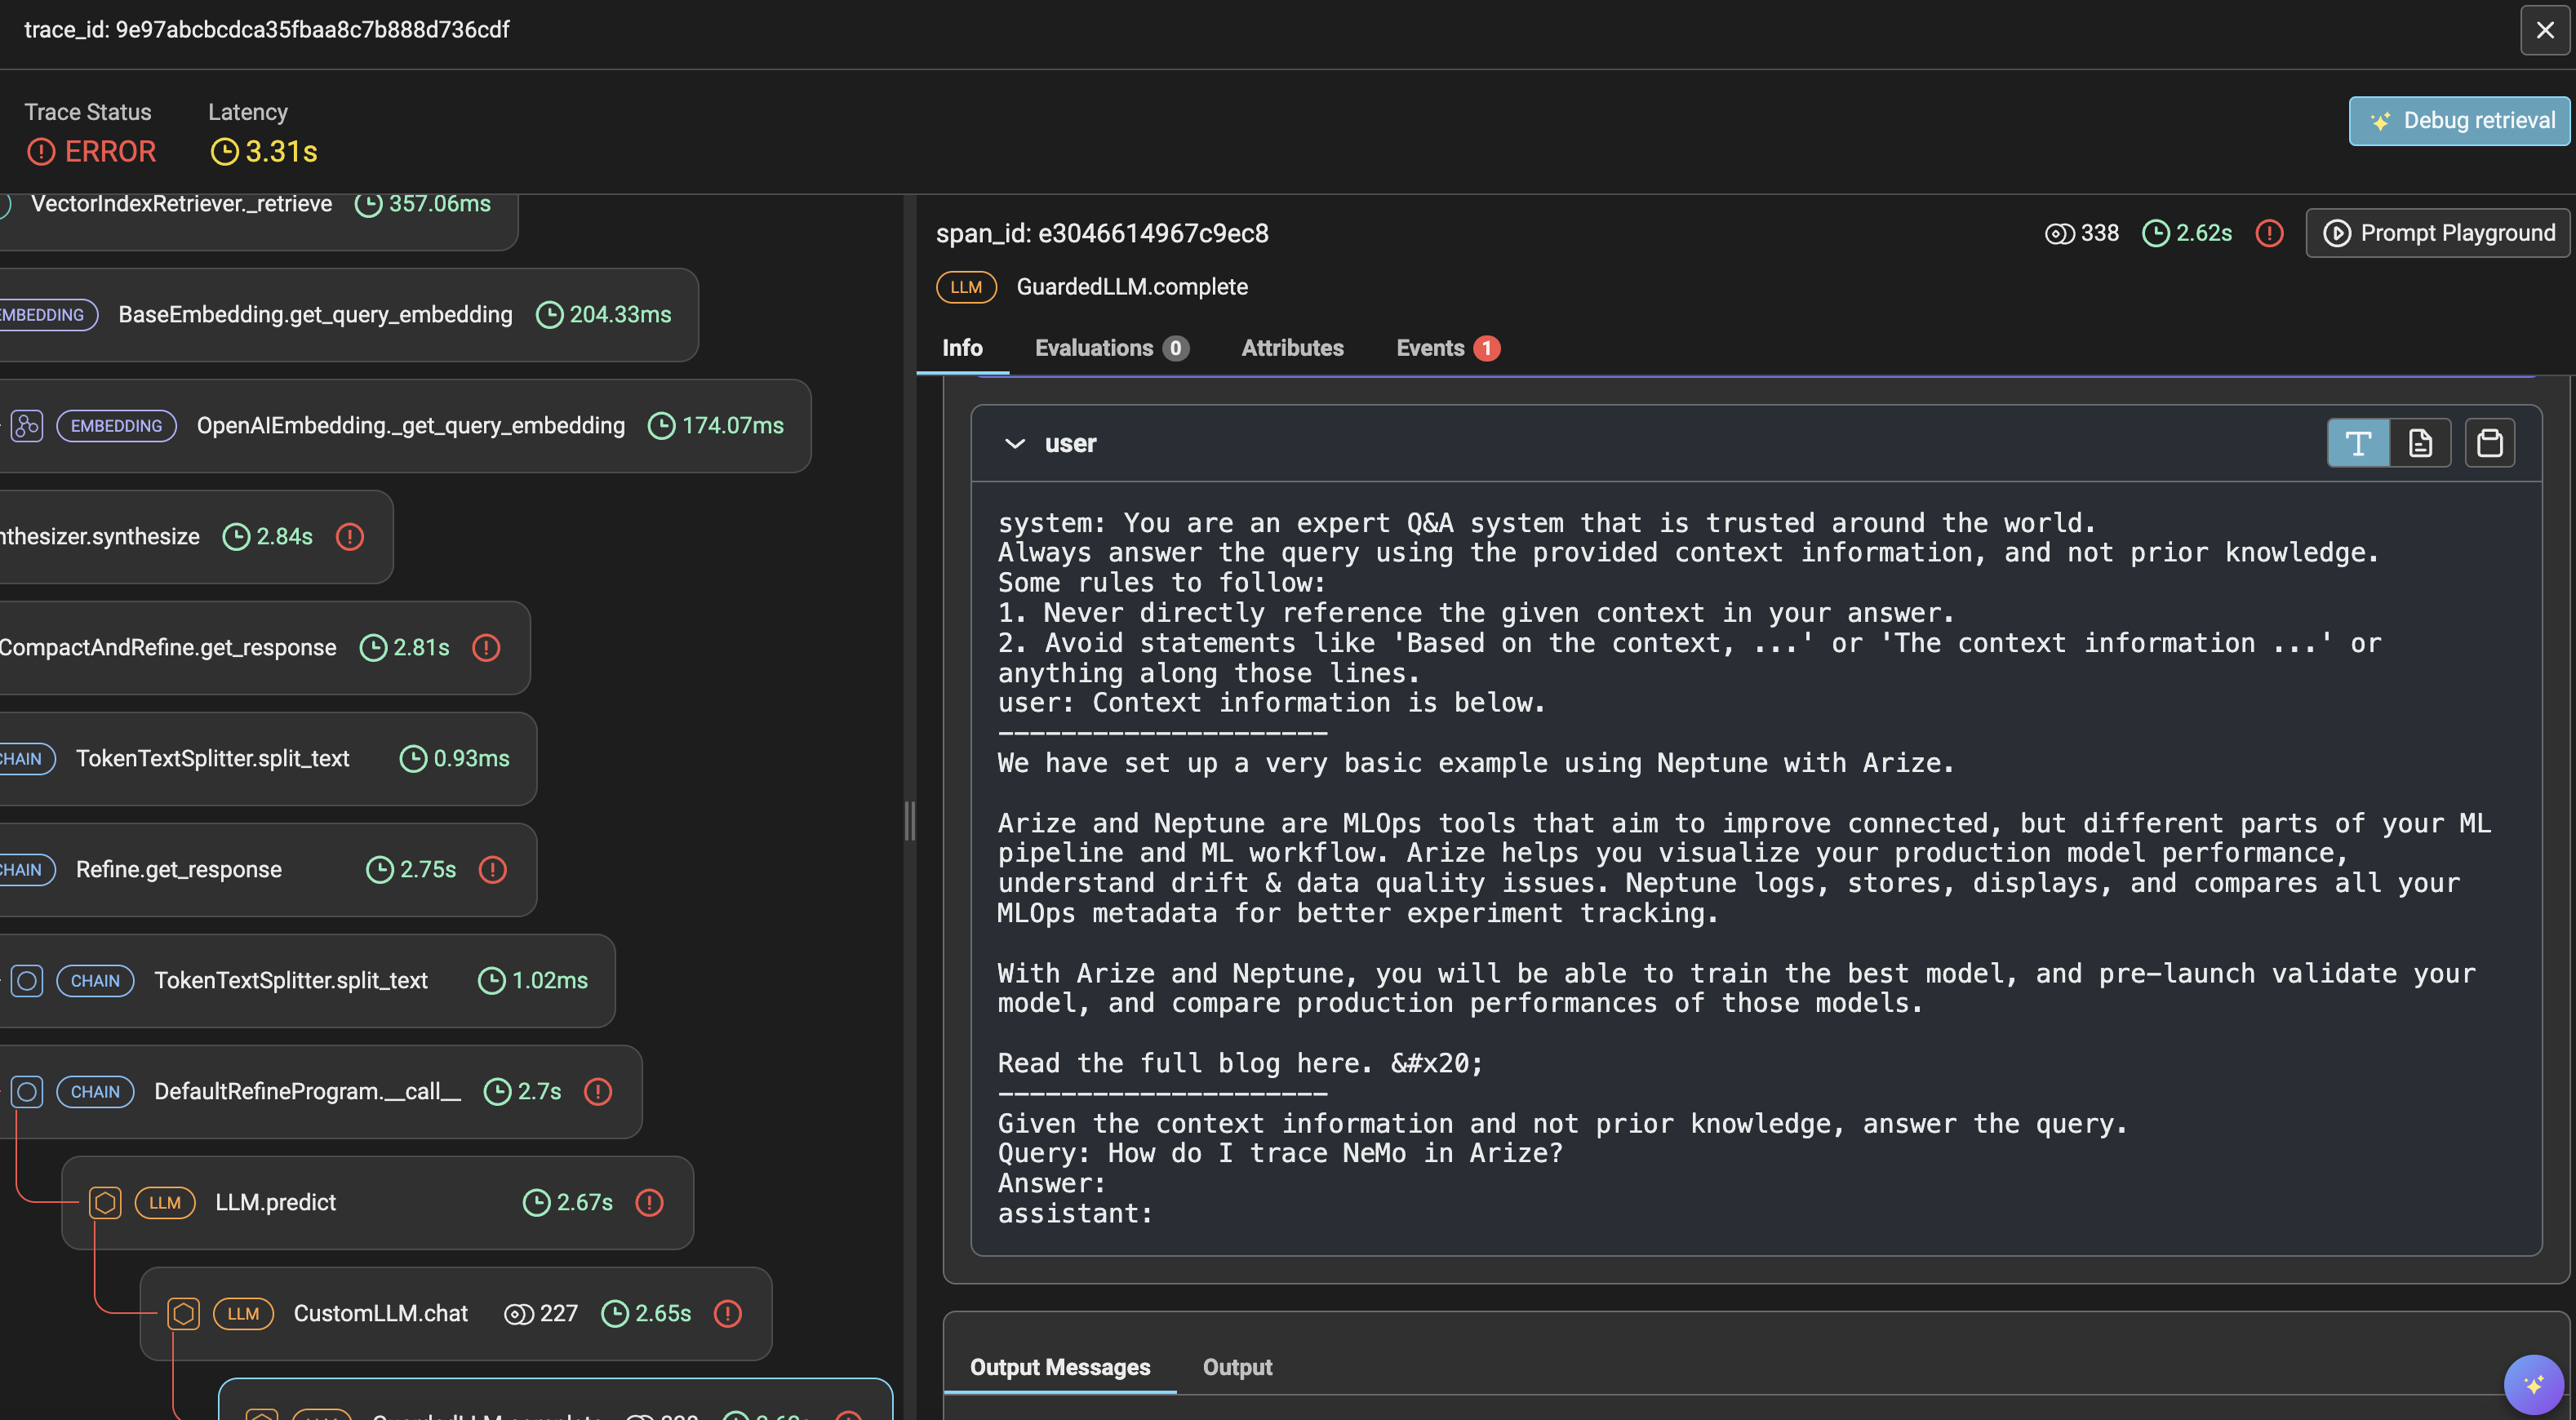

The `assistant` message shows the original LLM response that the Guard evaluated.

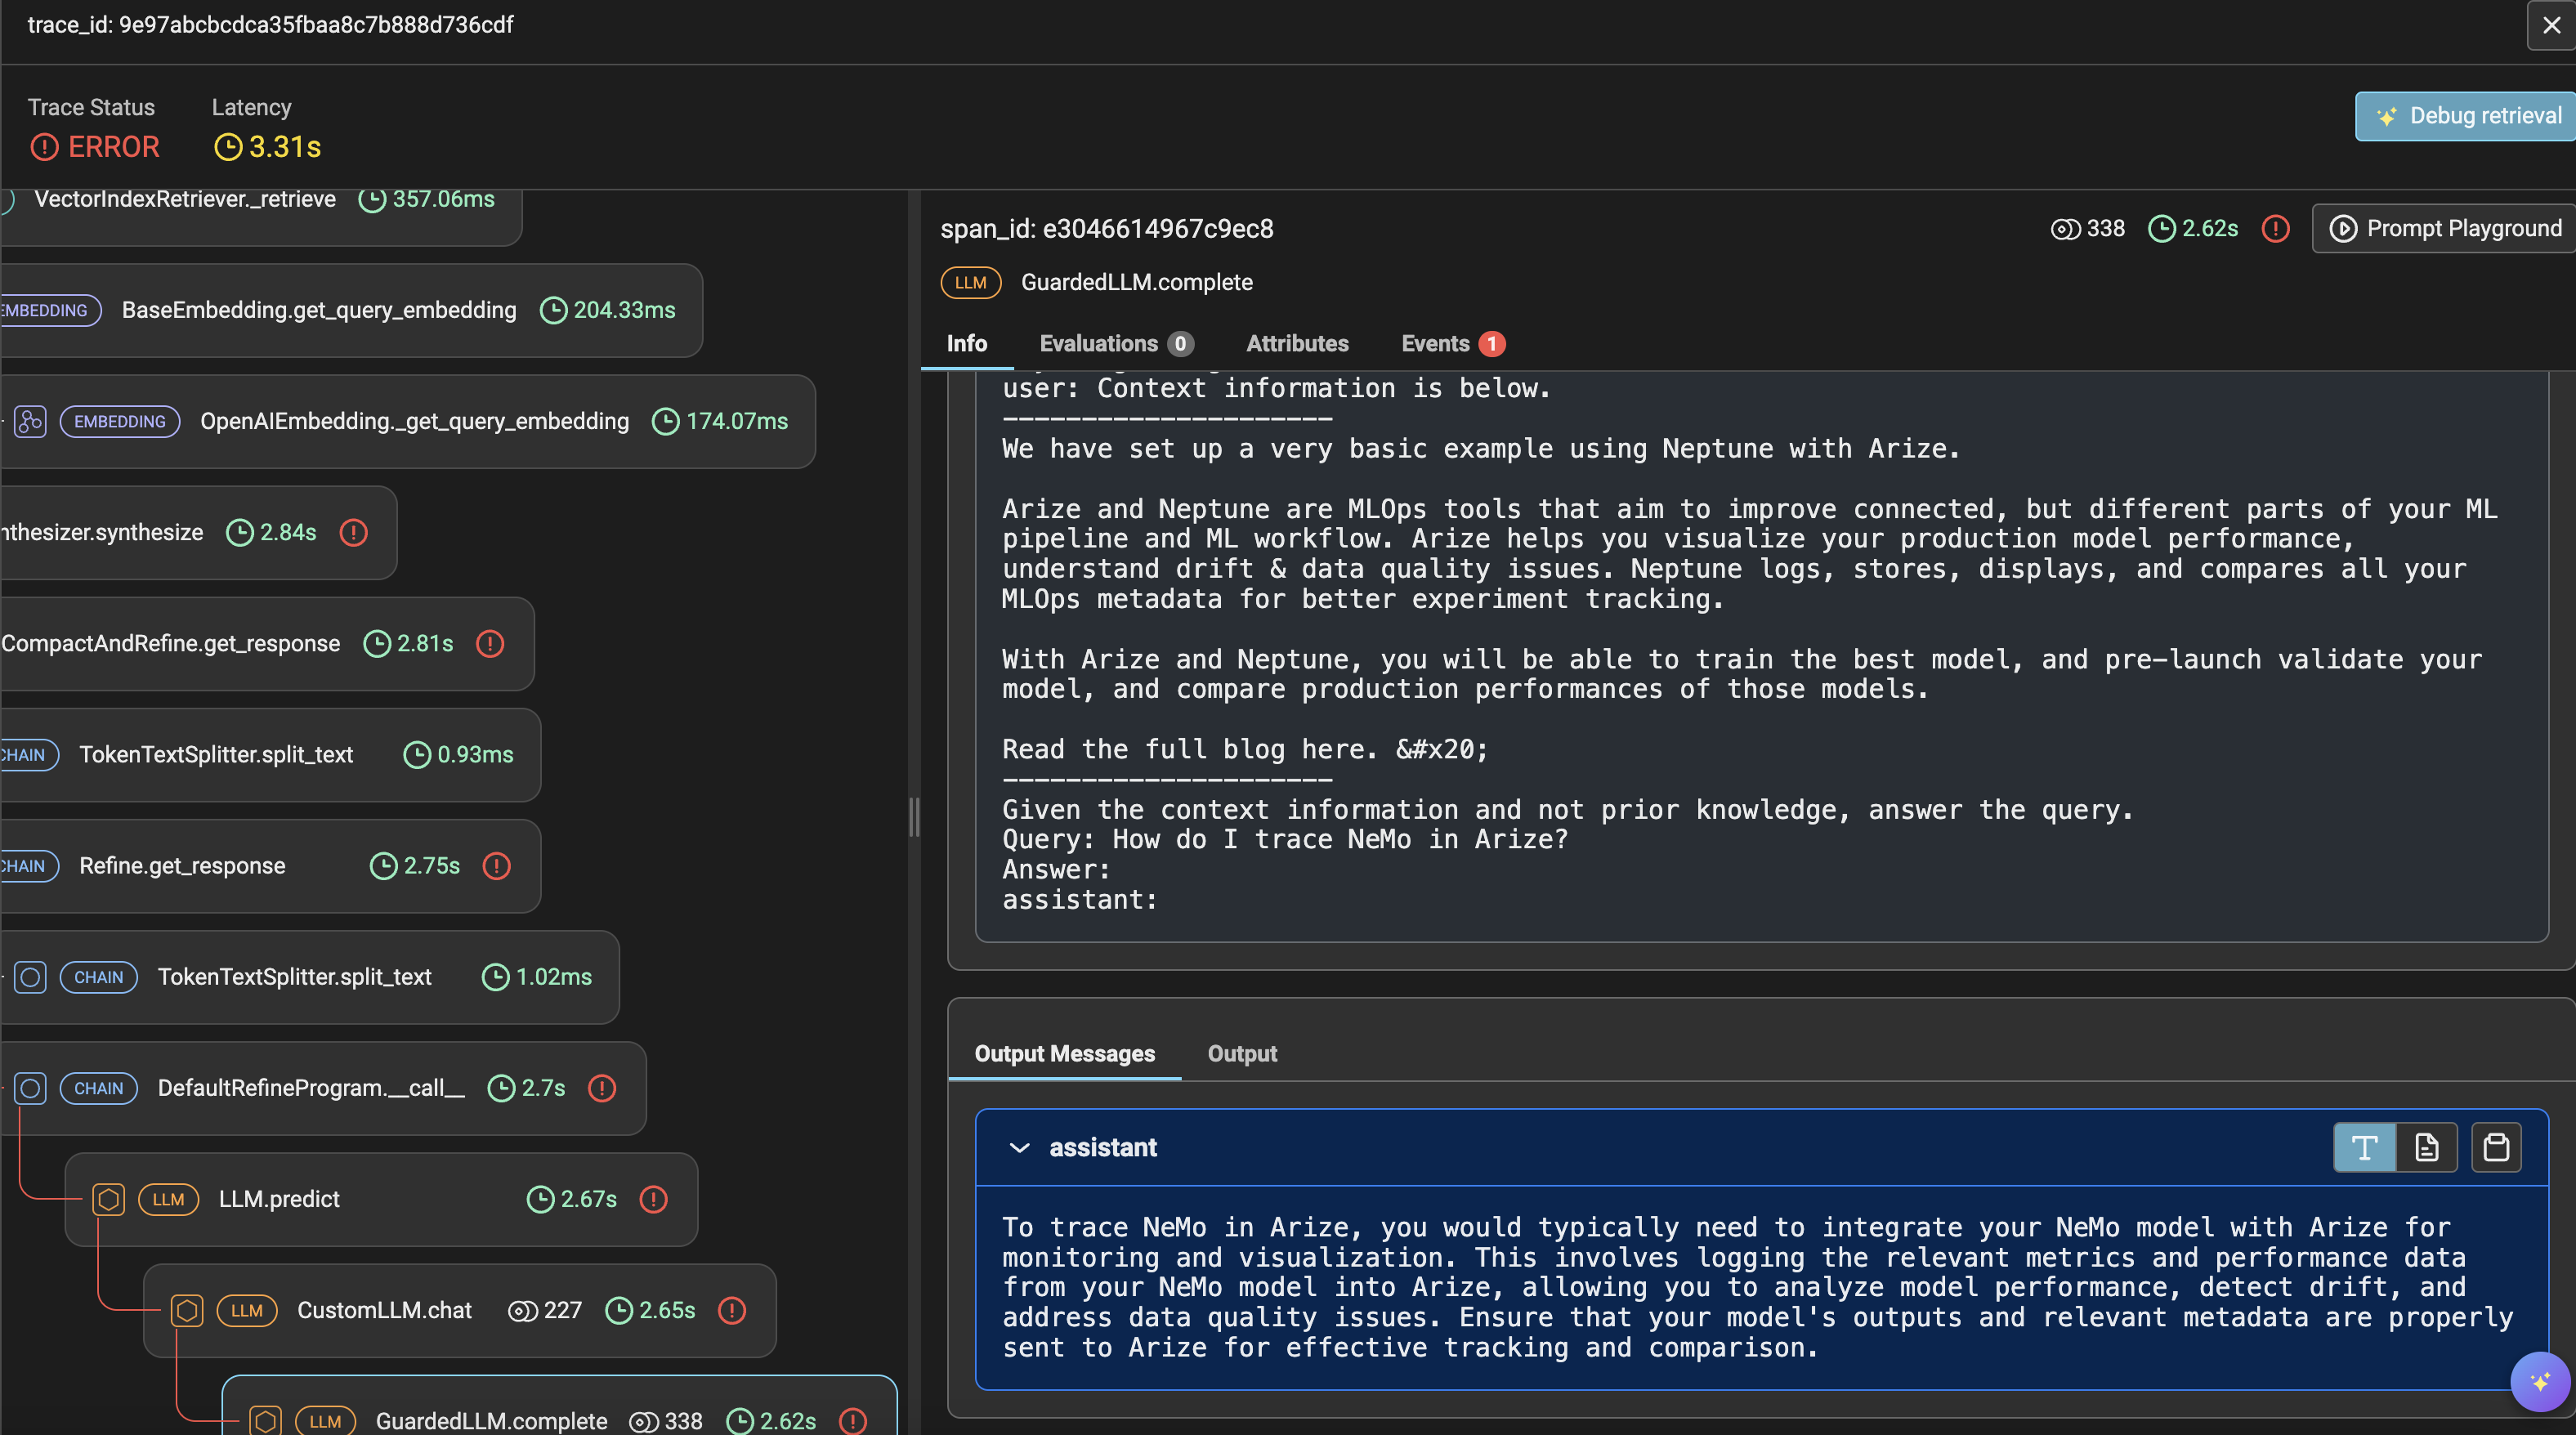

The `exception` below shows the response from the Guard, where it flags that the LLM response is a hallucination, since NeMo is not referenced in the context.

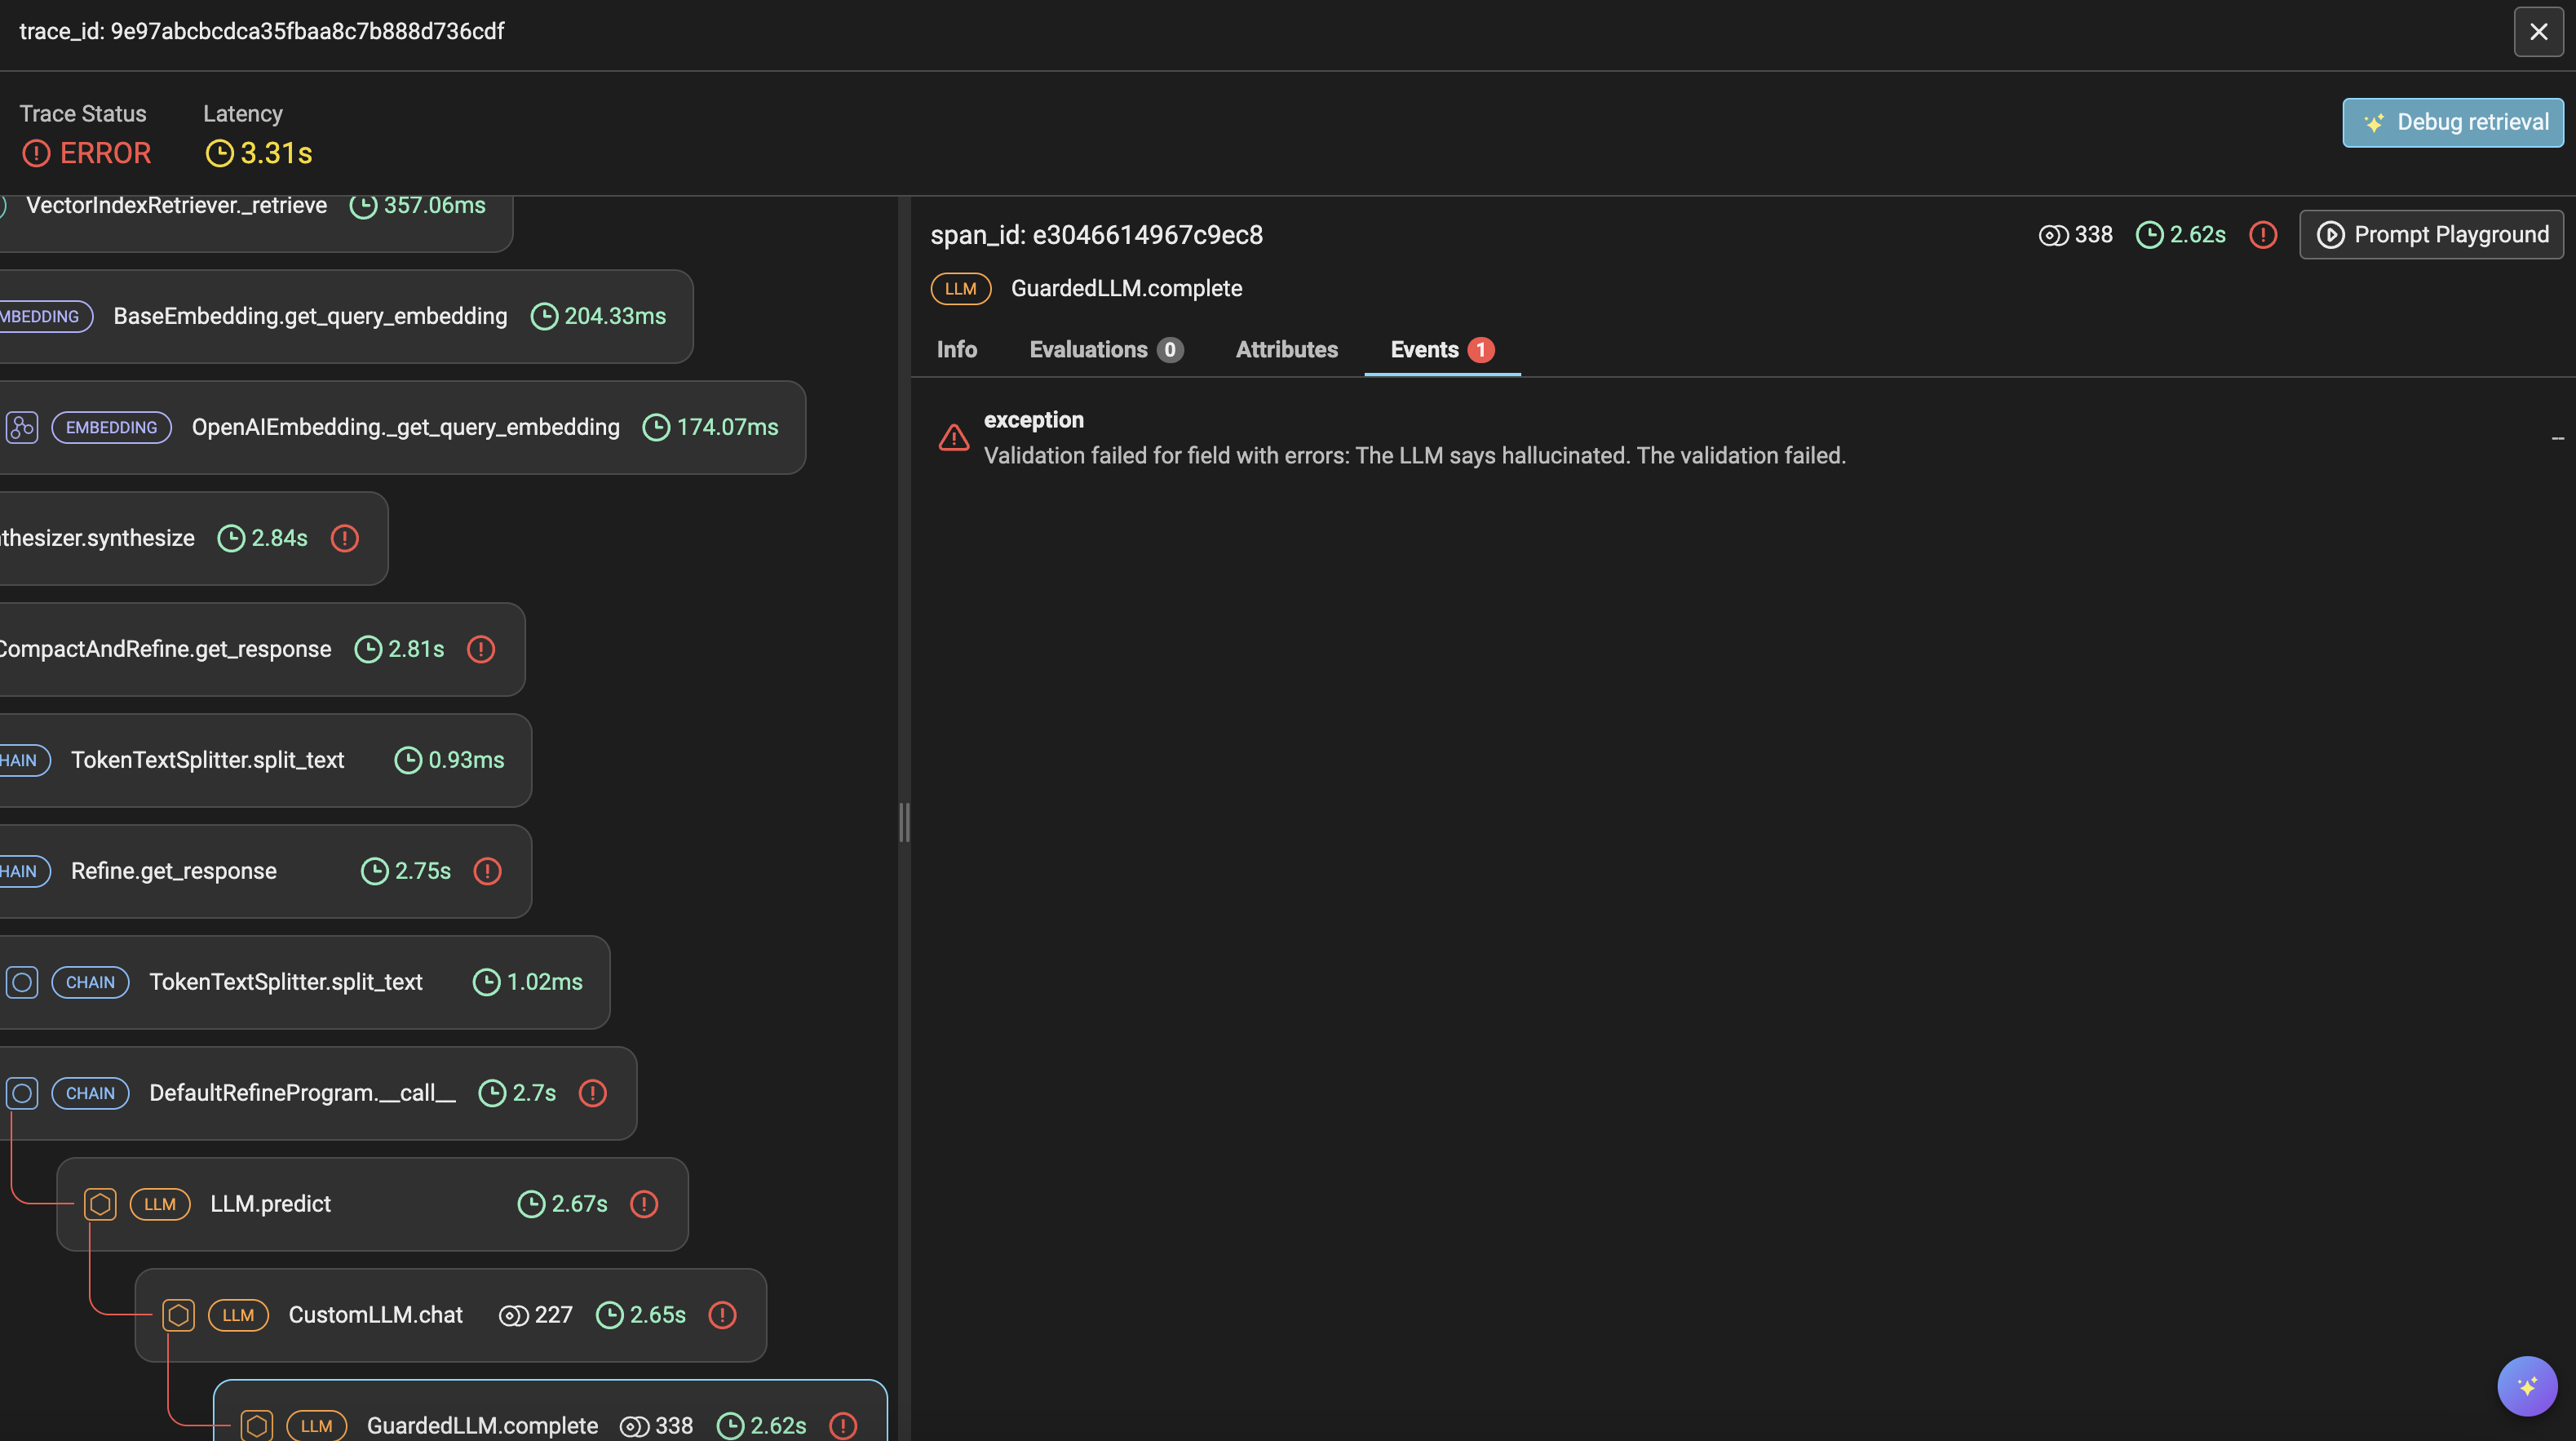

We can navigate over to the `Prompt Playground` to improve the LLM system prompt so that it is less likely to hallucinate in the future.

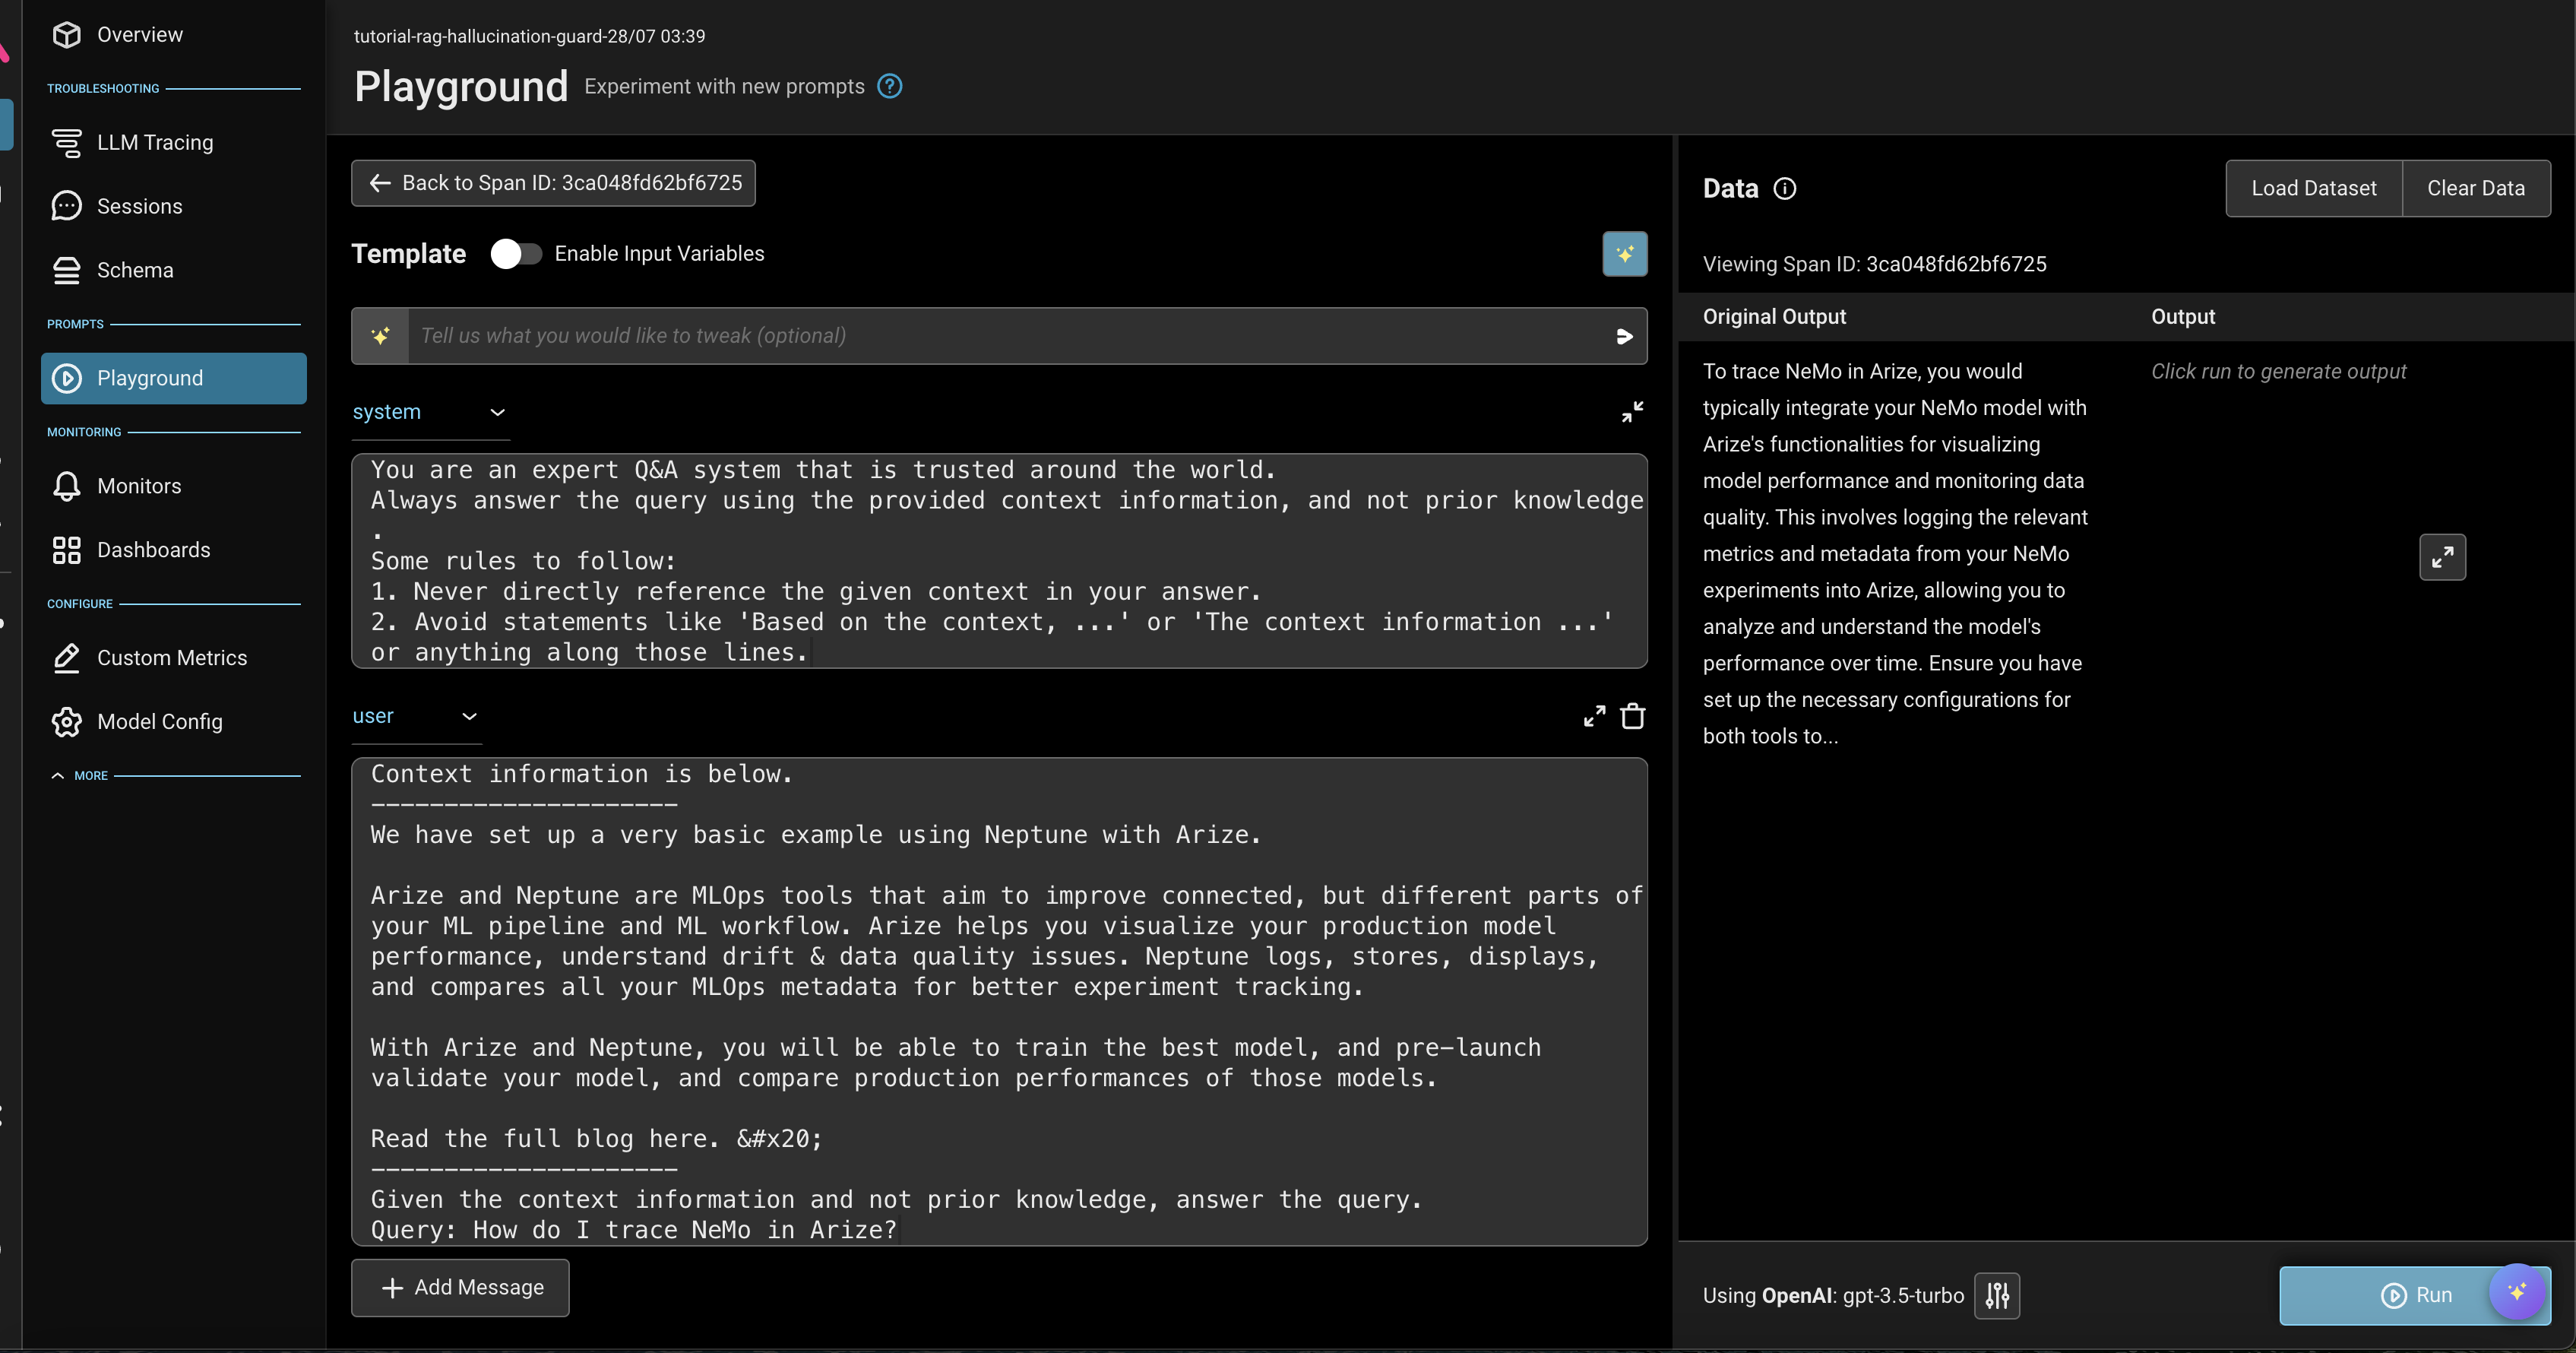

We add the sentence `IF YOU DO NOT KNOW THE ANSWER, RESPOND WITH "I DON'T KNOW"` to the `system` prompt. When we re-run the LLM, the model responds with "I DON'T KNOW" instead of hallucinating a response.

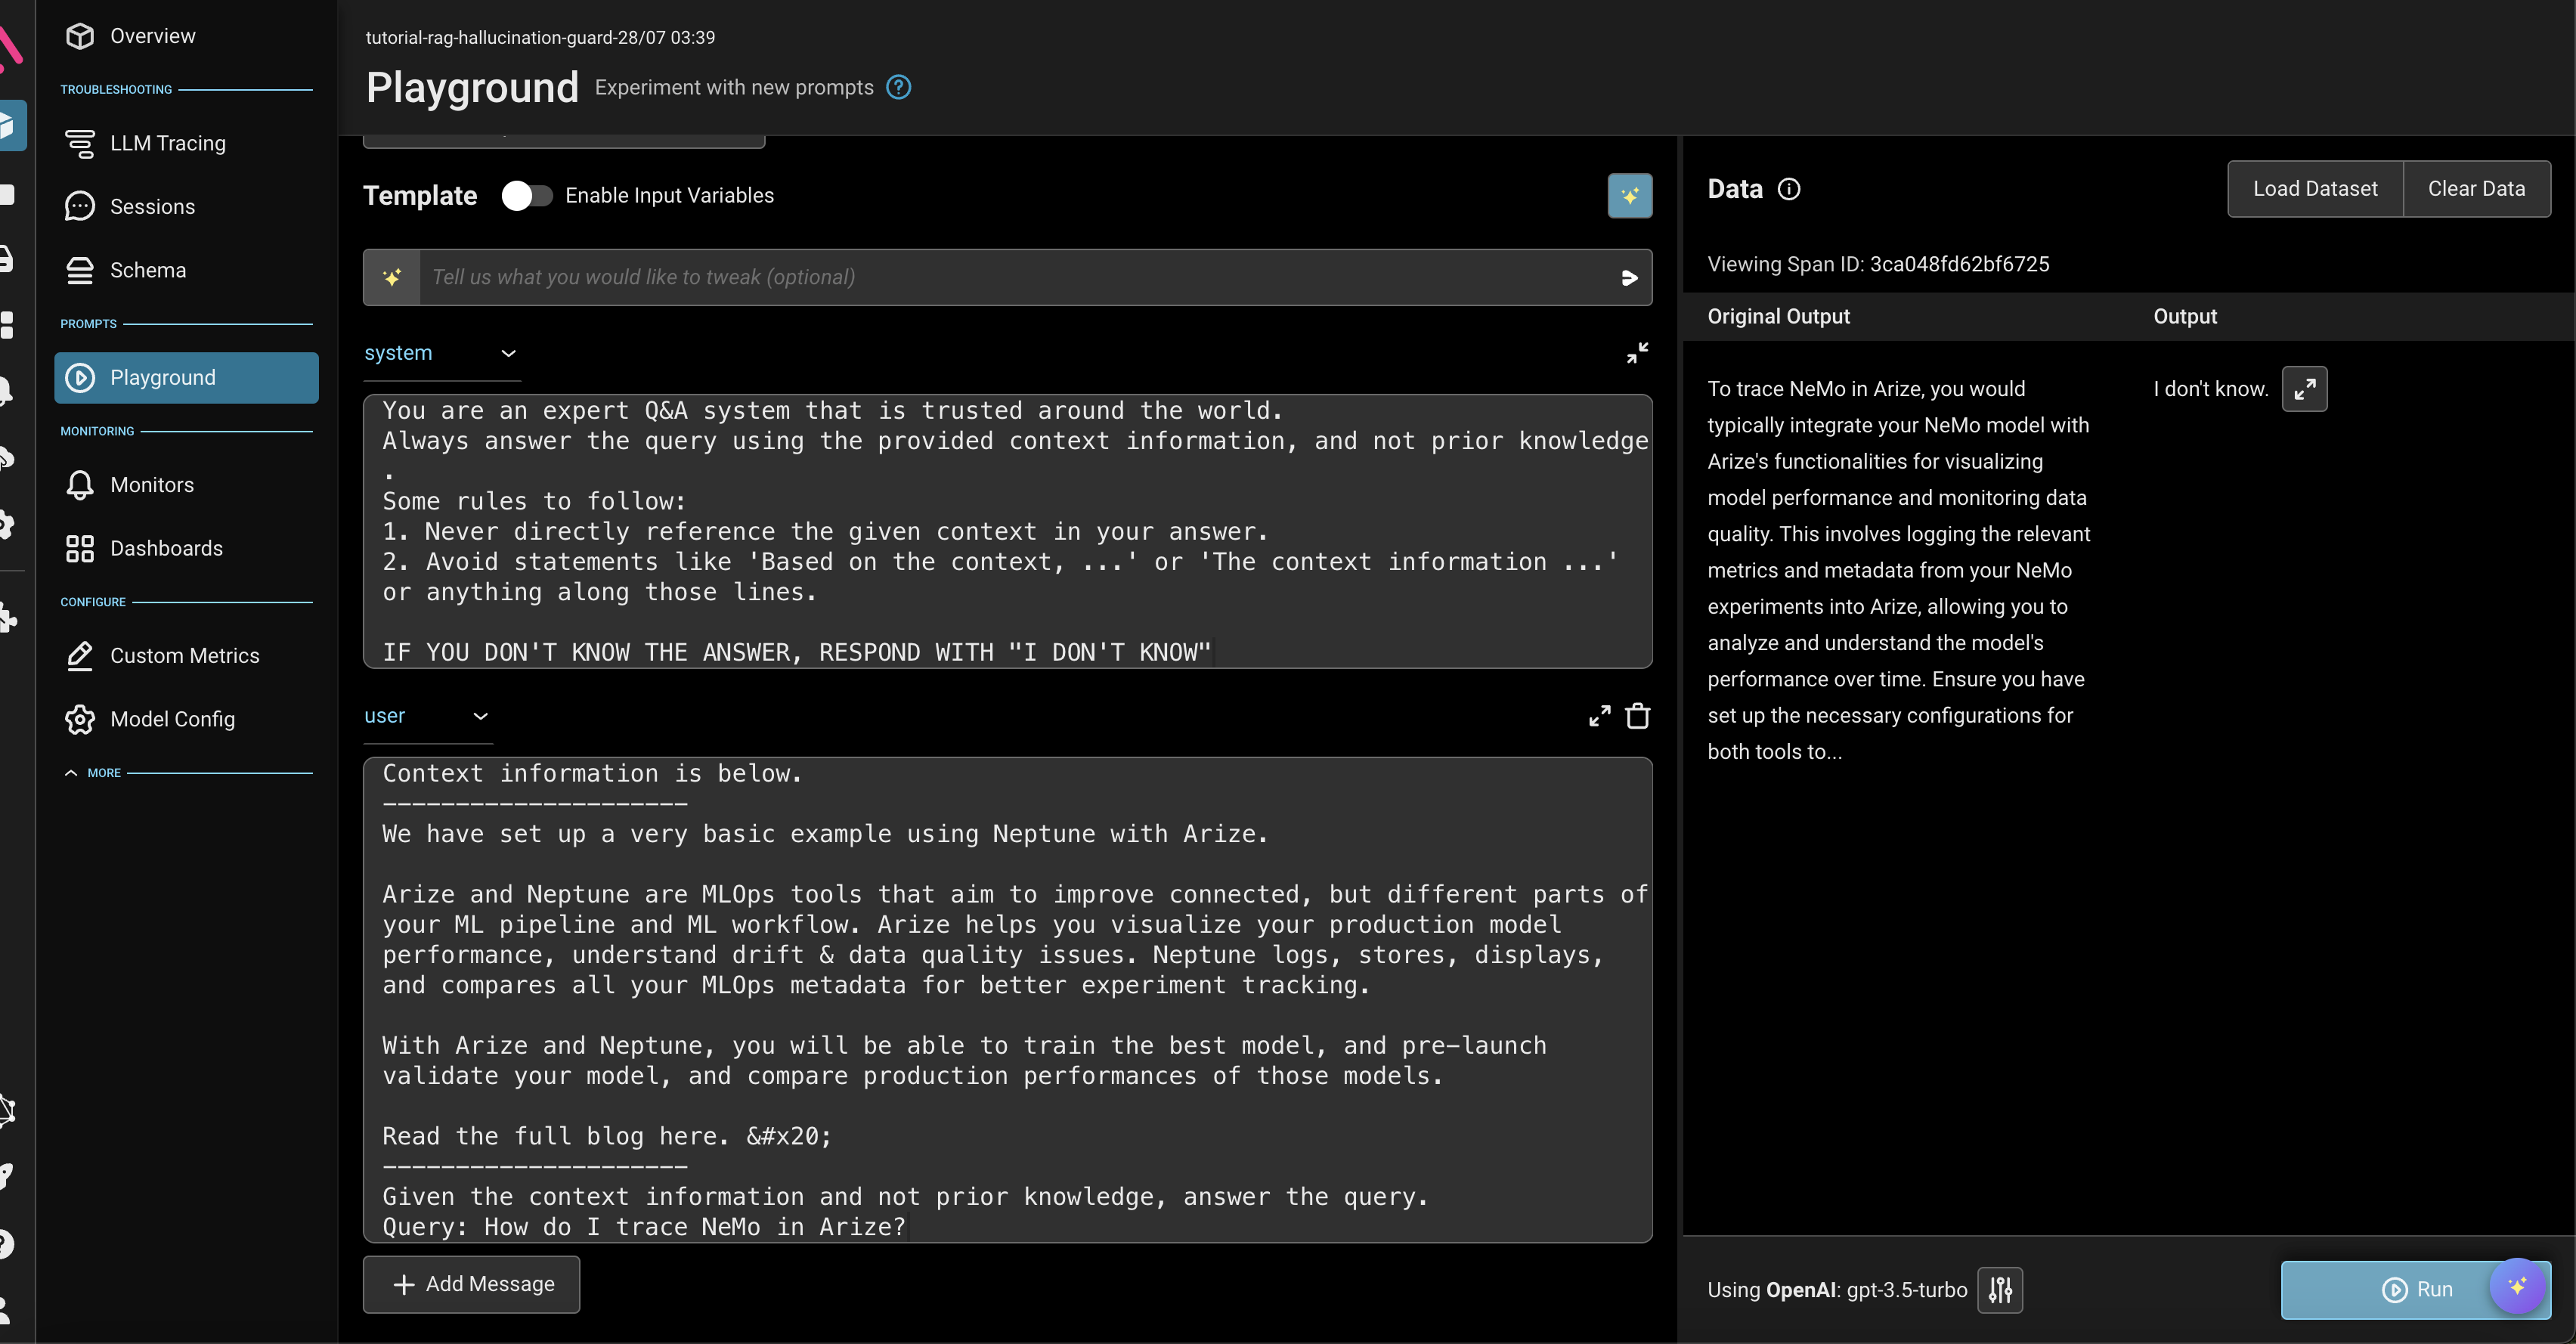